In [40]:
library(tidyverse)
library(arules)
library(rpart)
library(rpart.plot)
library(ipred)
library(gbm)
library(randomForest)
library(caret)
setwd("C:/Users/lee/Desktop/데이터마이닝특강/Final Project")

Warning message:
"패키지 'caret'는 R 버전 4.1.3에서 작성되었습니다"


ERROR: Error: package or namespace load failed for 'caret' in loadNamespace(j <- i[[1L]], c(lib.loc, .libPaths()), versionCheck = vI[[j]]):
 'hardhat'이라고 불리는 패키지가 없습니다


# 1

## (a)

In [22]:
data(Income)
inspect(Income[1])

    items                          transactionID
[1] {income=$40,000+,                           
     sex=male,                                  
     marital status=married,                    
     age=35+,                                   
     education=college graduate,                
     occupation=homemaker,                      
     years in bay area=10+,                     
     dual incomes=no,                           
     number in household=2+,                    
     number of children=1+,                     
     householder status=own,                    
     type of home=house,                        
     ethnic classification=white,               
     language in home=english}                 2


## (b)

In [23]:
glimpse(Income)
v <- tibble(unique(Income@itemInfo$variables))
v <- v %>% mutate(col_index = 1:nrow(v)) %>% select(2,1)
names(v)[2] <- "variable"
write_excel_csv(v,"1-b.csv")

Formal class 'transactions' [package "arules"] with 3 slots
  ..@ data       :Formal class 'ngCMatrix' [package "Matrix"] with 5 slots
  ..@ itemInfo   :'data.frame':	50 obs. of  3 variables:
  .. ..$ labels   : chr [1:50] "income=$0-$40,000" "income=$40,000+" "sex=male" "sex=female" ...
  .. ..$ variables: Factor w/ 14 levels "age","dual incomes",..: 6 6 12 12 8 8 8 8 8 1 ...
  .. ..$ levels   : Factor w/ 48 levels "0","$0-$40,000",..: 2 10 28 22 29 16 19 47 42 6 ...
  ..@ itemsetInfo:'data.frame':	6876 obs. of  1 variable:
  .. ..$ transactionID: chr [1:6876] "2" "3" "4" "5" ...


## (c)

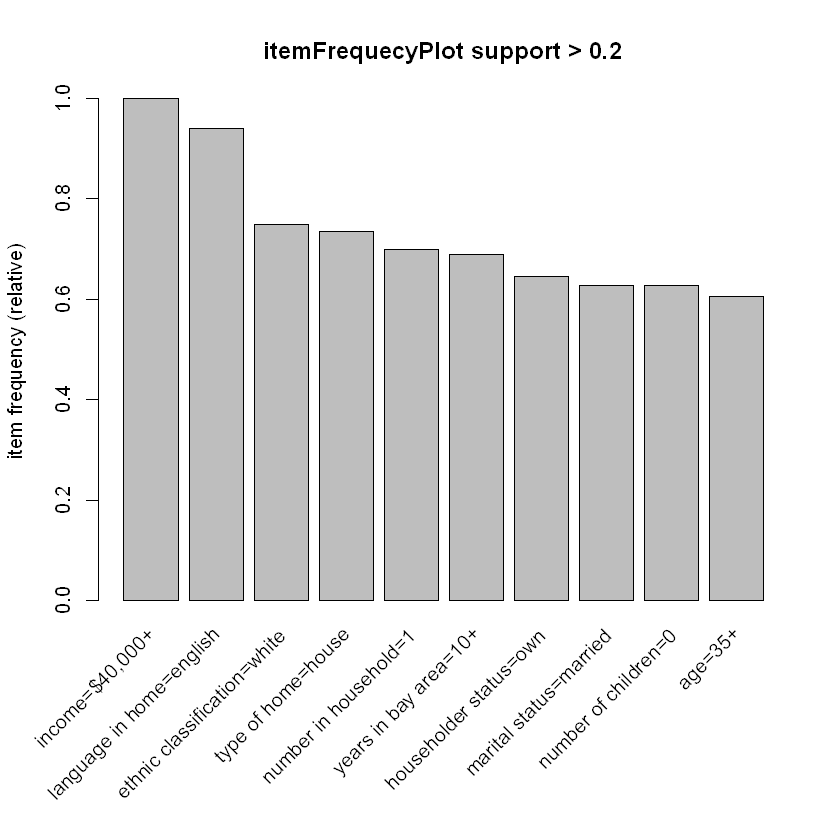

In [24]:
Income_4 <- Income[Income %in% "income=$40,000+"]
itemFrequencyPlot(Income_4,support=0.2,topN=10,main="itemFrequecyPlot support > 0.2")

## (d)

In [25]:
rules <- apriori(Income_4,parameter = list(support=0.1,
                                           confidence=0.8))

rules_1 <- subset(rules, 
                    subset = rhs %in% "income=$40,000+" & lift ==1)
rules_1 <- subset(rules, 
                  subset = !(rhs %in% "dual incomes=not married"))

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.8    0.1    1 none FALSE            TRUE       5     0.1      1
 maxlen target  ext
     10  rules TRUE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 259 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[49 item(s), 2596 transaction(s)] done [0.00s].
sorting and recoding items ... [26 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 4 5 6 7 8 9 10

Warning message in apriori(Income_4, parameter = list(support = 0.1, confidence = 0.8)):
"Mining stopped (maxlen reached). Only patterns up to a length of 10 returned!"


 done [0.02s].
writing ... [29323 rule(s)] done [0.00s].
creating S4 object  ... done [0.01s].


In [26]:
top5 <- inspect(sort(rules_1,by=c("confidence"),decreasing = T)[2:6])
top5

    lhs                                              rhs                 support confidence  coverage lift count
[1] {householder status=live with parents/family} => {income=$40,000+} 0.1009245          1 0.1009245    1   262
[2] {type of home=apartment}                      => {income=$40,000+} 0.1359784          1 0.1359784    1   353
[3] {dual incomes=no}                             => {income=$40,000+} 0.2014638          1 0.2014638    1   523
[4] {marital status=single}                       => {income=$40,000+} 0.2087827          1 0.2087827    1   542
[5] {householder status=rent}                     => {income=$40,000+} 0.2538521          1 0.2538521    1   659


NULL

***

# 2

## (a)

In [28]:
set.seed(1234)
data2 <- read_csv("sample_DT.csv")
#glimpse(data2)
data2$DEFECT_TYPE <- as.factor(data2$DEFECT_TYPE)
train <- data2 %>% sample_frac(0.7)
test <- setdiff(data2,train)

Rows: 10000 Columns: 21

-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
chr  (1): DEFECT_TYPE
dbl (20): ValueG, DIFF_BRG, ValueR, DEFECT_RBG, PKR.B, MinG, DEFECT_SIZE_Y, ...


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.



## (b)

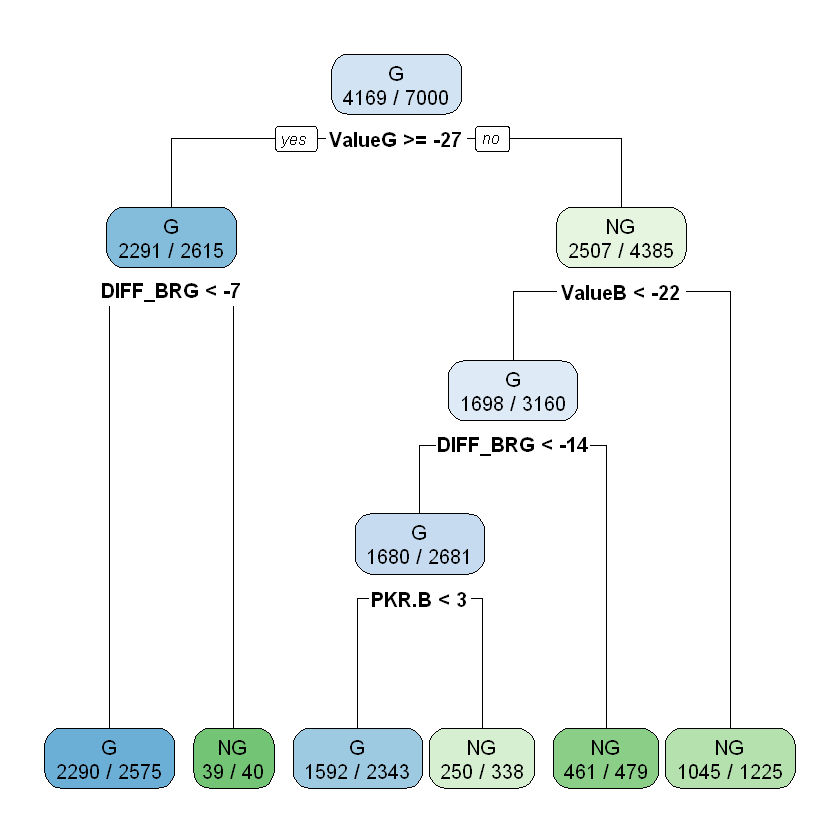

In [31]:
tree.fit <- rpart(DEFECT_TYPE~.,  
                  control = rpart.control(maxdepth=5,
                                         minsplit=15),data=train)
#tree.fit$cptable
#rpart.plot(tree.fit)
opt <- which.min(tree.fit$cptable[,"xerror"])
cp  <- tree.fit$cptable[opt,"CP"]
#plotcp(tree.fit)
prune.c <- prune(tree.fit,cp=cp)
rpart.plot(prune.c,extra=2)

## (c)

In [32]:
bagg.fit<- ipredbagg(train$DEFECT_TYPE, 
                     train[,-21],
                     nbagg=1000, 
                     coob=T) 

## (d)

In [ ]:
train_1 <- train
unique(train_1$DEFECT_TYPE)
train_1$DEFECT_TYPE <- ifelse(train_1$DEFECT_TYPE=="G",1,0)

test_1 <- test
test_1$DEFECT_TYPE <- ifelse(test_1$DEFECT_TYPE=="G",1,0)


boost.fit <- gbm(DEFECT_TYPE~.,
                      data=train_1,
                      distribution='bernoulli',
                      interaction.depth = 5,
                      n.trees=1000)

## (e)

In [33]:
rf.fit <- randomForest(DEFECT_TYPE ~.,
                          data = train, ntree = 50,
                          mtry = 6,
                          importance=T)

## (f)